In [1]:
import tensorflow
tensorflow.__version__

'2.3.1'

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


In [3]:
# Resizinig all the images to (224,224)
IMAGE_SIZE = [128,128]

train_path = 'Skin Disease Classification/Train'
test_path = 'Skin Disease Classification/Test'

In [4]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(128,128),
                                              batch_size=32,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(128,128),
                                            batch_size=32,
                                            class_mode='categorical')

Found 1392 images belonging to 6 classes.
Found 70 images belonging to 6 classes.


# **ResNet50**

In [6]:
resnet = ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [7]:
for layer in resnet.layers:
  layer.trainable = False

In [8]:
x = Flatten()(resnet.output)

In [9]:
prediction = Dense(6, activation='softmax')(x)

In [10]:
model = Model(inputs = resnet.inputs, outputs = prediction)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [11]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = model.fit_generator(train_set, validation_data=test_set, epochs=20, steps_per_epoch=1, validation_steps=1,callbacks=[callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 1.8192 - accuracy: 0.0625 - val_loss: 1.9423 - val_accuracy: 0.2188
Epoch 2/20
1/1 [==============================] - 4s 4s/step - loss: 1.5121 - accuracy: 0.3125 - val_loss: 2.0046 - val_accuracy: 0.2188
Epoch 3/20
1/1 [==============================] - 4s 4s/step - loss: 1.5672 - accuracy: 0.2500 - val_loss: 2.1593 - val_accuracy: 0.3438
Epoch 4/20
1/1 [==============================] - 7s 7s/step - loss: 1.9080 - accuracy: 0.3750 - val_loss: 2.0219 - val_accuracy: 0.2812
Epoch 5/20
1/1 [==============================] - 6s 6s/step - loss: 2.5971 - accuracy: 0.0938 - val_loss: 2.4858 - val_accuracy: 0.2812


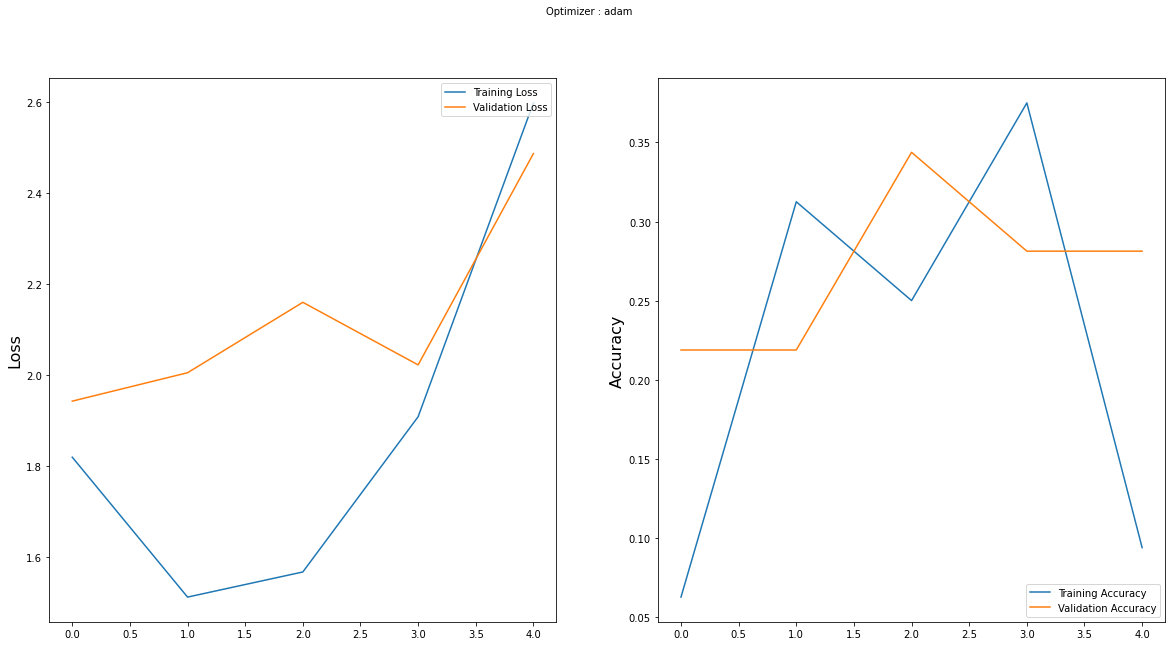

In [13]:
import matplotlib.pyplot as plt

x=hist
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# **InceptionV3**

In [14]:
# create the base pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x2 = base_model.output
x2 = GlobalAveragePooling2D()(x2)

In [15]:
predictions = Dense(6, activation='softmax')(x2)

# this is the model we will train
models = Model(inputs=base_model.input, outputs=predictions)
models.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [16]:
for layer in base_model.layers:
    layer.trainable = False


In [17]:
models.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = models.fit_generator(train_set, validation_data=train_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(train_set),callbacks=[callback])

Epoch 1/20
44/44 [==============================] - 69s 2s/step - loss: 1.7602 - accuracy: 0.3858 - val_loss: 1.3142 - val_accuracy: 0.5108
Epoch 2/20
44/44 [==============================] - 73s 2s/step - loss: 1.3548 - accuracy: 0.5036 - val_loss: 1.2861 - val_accuracy: 0.5431
Epoch 3/20
44/44 [==============================] - 72s 2s/step - loss: 1.1829 - accuracy: 0.5632 - val_loss: 1.1283 - val_accuracy: 0.5711
Epoch 4/20
44/44 [==============================] - 73s 2s/step - loss: 1.0870 - accuracy: 0.5948 - val_loss: 1.0037 - val_accuracy: 0.6322
Epoch 5/20
44/44 [==============================] - 74s 2s/step - loss: 1.0311 - accuracy: 0.6099 - val_loss: 0.9683 - val_accuracy: 0.6214
Epoch 6/20
44/44 [==============================] - 73s 2s/step - loss: 0.9836 - accuracy: 0.6401 - val_loss: 0.9293 - val_accuracy: 0.6609
Epoch 7/20
44/44 [==============================] - 73s 2s/step - loss: 0.9738 - accuracy: 0.6408 - val_loss: 0.9660 - val_accuracy: 0.6149
Epoch 8/20
44/44 [==

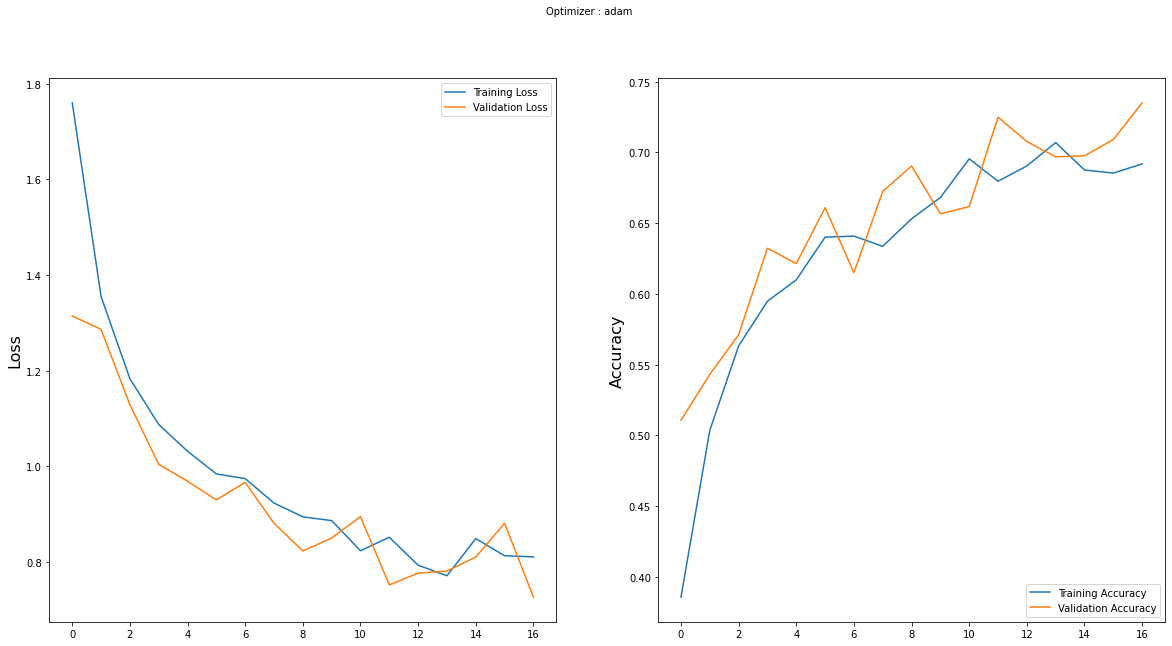

In [18]:
import matplotlib.pyplot as plt

x=hist
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# **MobileNet**

In [19]:
from tensorflow.keras.applications import MobileNet, MobileNetV2
mob = MobileNet(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [20]:
x1= Flatten()(mob.output)
prediction1 = Dense(6, activation='softmax')(x1)
model12 = Model(inputs = mob.inputs, outputs = prediction1)
model12.summary()
model12.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       

In [21]:
r1 = model12.fit_generator(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/20
44/44 [==============================] - 88s 2s/step - loss: 3.5368 - accuracy: 0.5402 - val_loss: 18.5847 - val_accuracy: 0.1286
Epoch 2/20
44/44 [==============================] - 96s 2s/step - loss: 2.0434 - accuracy: 0.7076 - val_loss: 11.4988 - val_accuracy: 0.2857
Epoch 3/20
44/44 [==============================] - 95s 2s/step - loss: 1.2468 - accuracy: 0.7579 - val_loss: 12.6180 - val_accuracy: 0.3857
Epoch 4/20
44/44 [==============================] - 97s 2s/step - loss: 0.8947 - accuracy: 0.7809 - val_loss: 8.4610 - val_accuracy: 0.4429
Epoch 5/20
44/44 [==============================] - 95s 2s/step - loss: 0.5134 - accuracy: 0.8305 - val_loss: 5.0951 - val_accuracy: 0.4714
Epoch 6/20
44/44 [==============================] - 96s 2s/step - loss: 0.3602 - accuracy: 0.8750 - val_loss: 4.3668 - val_accuracy: 0.4429
Epoch 7/20
44/44 [==============================] - 95s 2s/step - loss: 0.3714 - accuracy: 0.8736 - val_loss: 5.3735 - val_accuracy: 0.4571
Epoch 8/20
44/44 

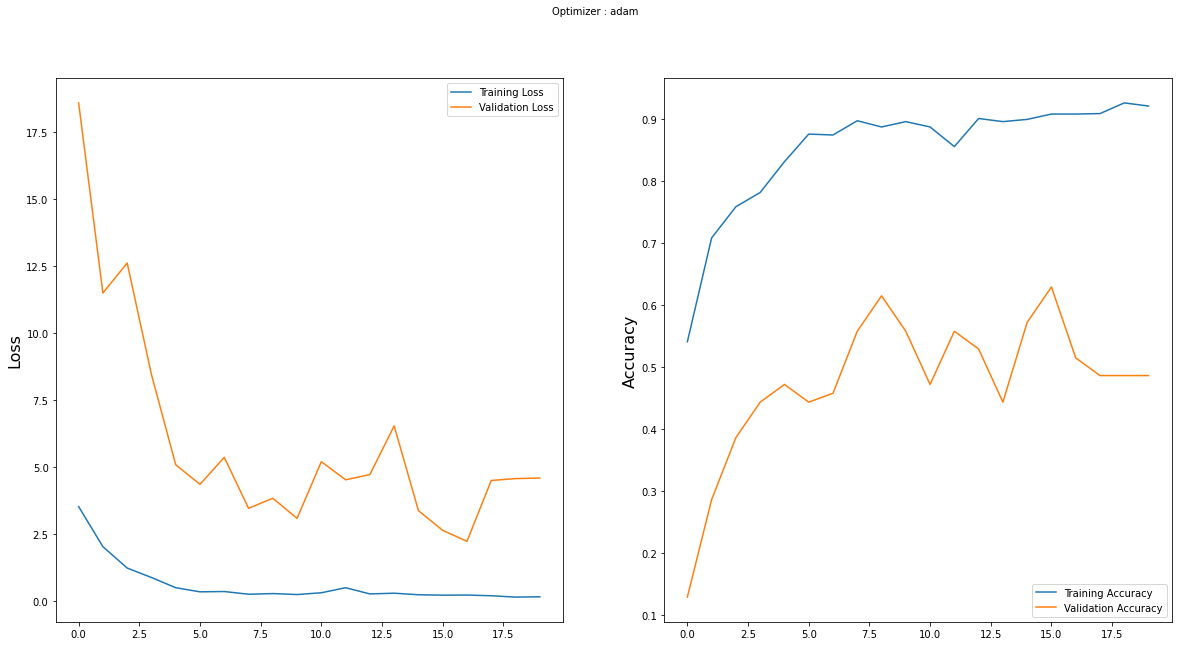

In [22]:
import matplotlib.pyplot as plt

x=r1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# **DenseNet121**

In [23]:
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, ResNet50V2,ResNet101V2,ResNet152V2

In [24]:
des121=DenseNet121(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [25]:
x1= Flatten()(des121.output)
prediction1 = Dense(6, activation='softmax')(x1)
model1 = Model(inputs = des121.inputs, outputs = prediction1)
model1.summary()
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [26]:
r1 = model1.fit_generator(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/20
44/44 [==============================] - 316s 7s/step - loss: 2.5667 - accuracy: 0.5481 - val_loss: 42.8536 - val_accuracy: 0.2429
Epoch 2/20
44/44 [==============================] - 318s 7s/step - loss: 1.6803 - accuracy: 0.6566 - val_loss: 6.2740 - val_accuracy: 0.2857
Epoch 3/20
44/44 [==============================] - 318s 7s/step - loss: 2.5704 - accuracy: 0.6422 - val_loss: 284.0741 - val_accuracy: 0.1429
Epoch 4/20
44/44 [==============================] - 319s 7s/step - loss: 2.8752 - accuracy: 0.5453 - val_loss: 78627.7734 - val_accuracy: 0.2286
Epoch 5/20
44/44 [==============================] - 319s 7s/step - loss: 1.8857 - accuracy: 0.5280 - val_loss: 3882.7715 - val_accuracy: 0.2286
Epoch 6/20
44/44 [==============================] - 319s 7s/step - loss: 1.4972 - accuracy: 0.6006 - val_loss: 203.5680 - val_accuracy: 0.3286
Epoch 7/20
44/44 [==============================] - 322s 7s/step - loss: 1.2575 - accuracy: 0.6243 - val_loss: 23.7258 - val_accuracy: 0.3571


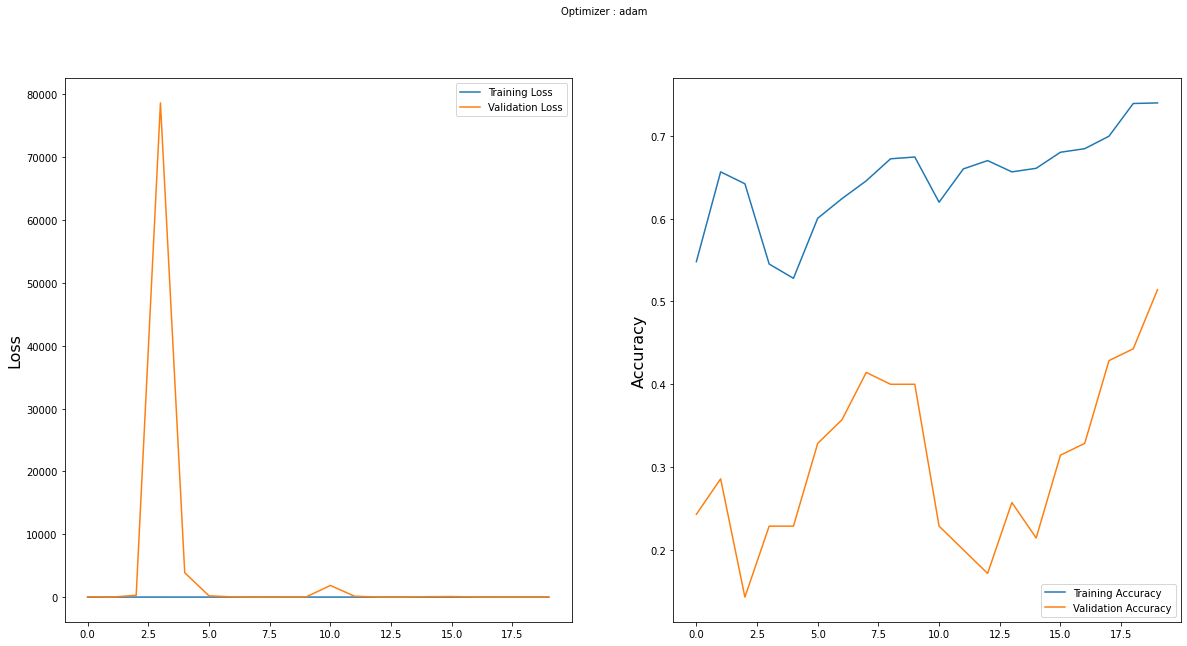

In [27]:
import matplotlib.pyplot as plt

x=r1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Xception

In [28]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

# Defining batch and epoch sizes
batch_size = 100
epochs = 20

# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(6, activation='softmax')(x)
# Combining base and head 
model3 = Model(inputs=base.input, outputs=head)

# Compiling the model
model3.compile(optimizer=Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

# Fitting the model with train and validation augmented datasets.
history = model3.fit(train_set,
                              epochs = 20,
                              validation_data = train_set)

83689472/83683744 [==============================] - 10s 0us/step
Epoch 1/20
44/44 [==============================] - 411s 9s/step - loss: 1.4507 - accuracy: 0.5022 - val_loss: 1.2723 - val_accuracy: 0.5704
Epoch 2/20
44/44 [==============================] - 413s 9s/step - loss: 0.8107 - accuracy: 0.7543 - val_loss: 0.8810 - val_accuracy: 0.7055
Epoch 3/20
44/44 [==============================] - 412s 9s/step - loss: 0.5140 - accuracy: 0.8283 - val_loss: 0.5926 - val_accuracy: 0.7909
Epoch 4/20
44/44 [==============================] - 411s 9s/step - loss: 0.3638 - accuracy: 0.8743 - val_loss: 0.3647 - val_accuracy: 0.8678
Epoch 5/20
44/44 [==============================] - 411s 9s/step - loss: 0.2619 - accuracy: 0.9030 - val_loss: 0.2858 - val_accuracy: 0.8937
Epoch 6/20
44/44 [==============================] - 411s 9s/step - loss: 0.2373 - accuracy: 0.9116 - val_loss: 0.1774 - val_accuracy: 0.9253
Epoch 7/20
44/44 [==============================] - 412s 9s/step - loss: 0.2059 - accura

In [29]:
model3.save('model.h5')

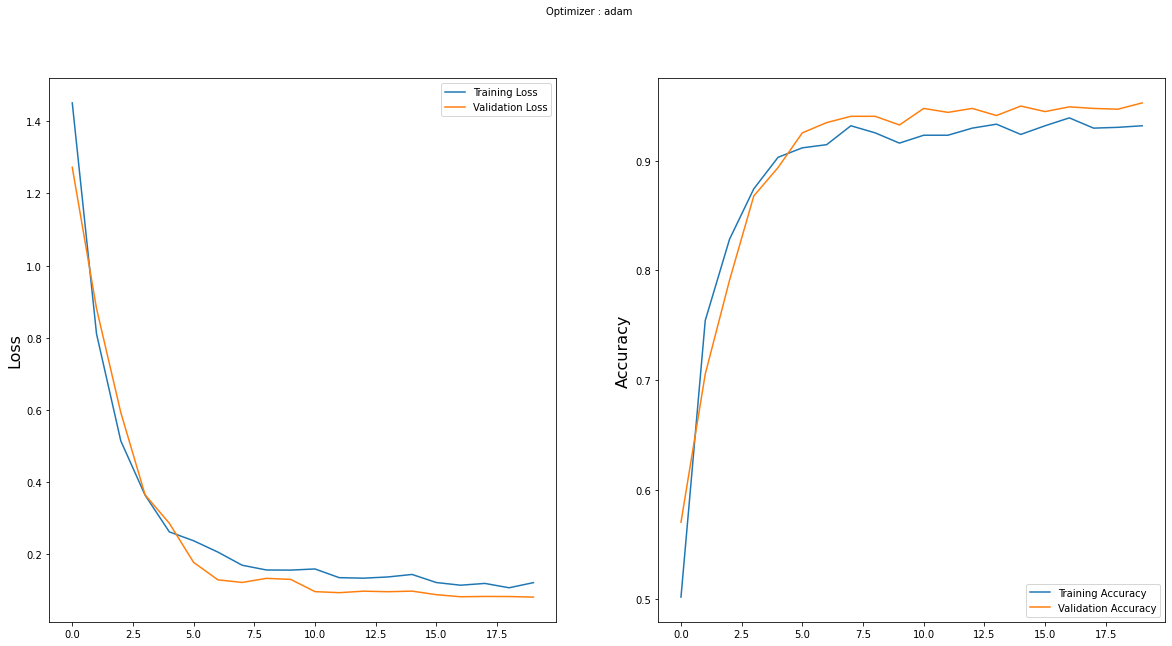

In [30]:
import matplotlib.pyplot as plt

x=history
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# EfficientNet

In [31]:
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical

In [33]:
lrr= ReduceLROnPlateau(monitor='val_acc',factor=.01,patience=3,min_lr=1e-5)
from keras_efficientnets import EfficientNetB4
base_model = EfficientNetB4(include_top=False, weights="imagenet", input_shape=(128,128,3),classes=6)

71720960/71719528 [==============================] - 15s 0us/step


In [34]:
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 
model.add(Dense(1024,activation=('relu'),input_dim=512))

model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
#model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(6,activation=('softmax'))) 

#Checking the final model summary
model.summary()

batch_size= 100
epochs=2
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_11 (Functional)   (None, 4, 4, 1792)        17673816  
_________________________________________________________________
flatten_3 (Flatten)          (None, 28672)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              29361152  
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 7

In [35]:
history = model.fit(train_set,
                              epochs = 2,
                              validation_data = test_set)

Epoch 1/2
44/44 [==============================] - 359s 8s/step - loss: 1.4969 - accuracy: 0.4109 - val_loss: 2.1683 - val_accuracy: 0.2857
Epoch 2/2
44/44 [==============================] - 355s 8s/step - loss: 1.1041 - accuracy: 0.6027 - val_loss: 2.0792 - val_accuracy: 0.2429


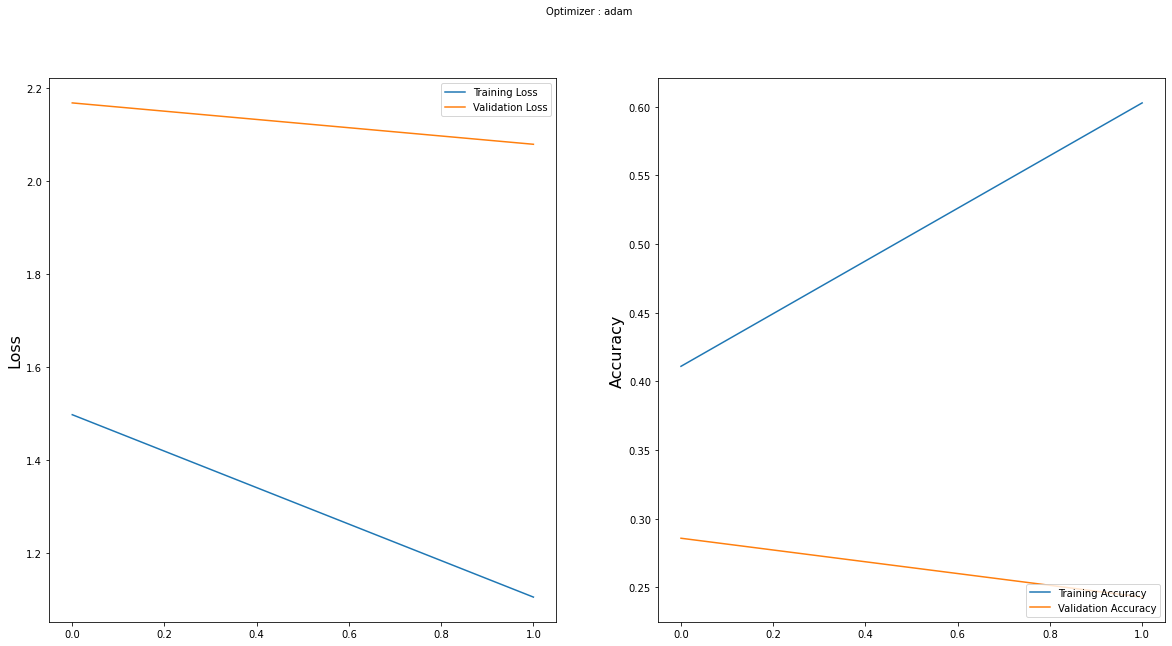

In [36]:
import matplotlib.pyplot as plt

x=history
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()